# Importing libraries and image file

In [11]:
import cv2                              # for working with images
from matplotlib import pyplot as plt    # for plotting images
import numpy as np                      # for matrix
import imutils                          # for grabbing contours
import easyocr                          # for detecting the characters from license plate
from os import path                     # for saving results

About the dataset we are using [Car License Plate Detection](https://www.kaggle.com/andrewmvd/car-plate-detection) dataset from Kaggle. It has 433 images of differnt types of complexity.

In [12]:
img = cv2.imread('images/Cars0.png') # load the image

# Pre-Processing

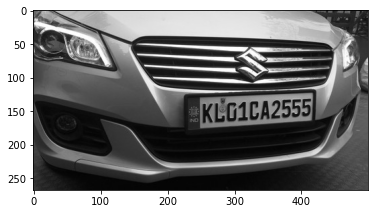

In [13]:
gsimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # converted image to grayscale
plt.imshow(cv2.cvtColor(gsimg, cv2.COLOR_BGR2RGB)) # plot image

We will be detecting edges from the image and it can be done only with the luminance value of each pixel. So to speed up the process and reduce the space consumption RGB pictures are converted to Grayscale before processing them.

Now before edge detection, we also have to remove any noise present in the picture by applying a filter.

We have many options for filter like
- Mean filter
- Median filter
- Gaussian filter
- Bilateral filter

Lets see which one is better for us

### Noise Reduction

**Mean Filter**

In this type of filter the mean of the neighbouring pixels are calculated and stored in central pixel. The shape of the sliding window is passed as parameters(here 5x5)

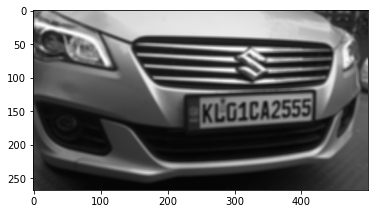

In [14]:
meanImg = cv2.blur(gsimg,(5, 5))
plt.imshow(cv2.cvtColor(meanImg, cv2.COLOR_BGR2RGB))

**Median Filter**

In this type of filter

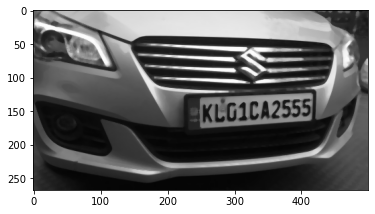

In [16]:
medianImg = cv2.medianBlur(gsimg, 5)
plt.imshow(cv2.cvtColor(medianImg, cv2.COLOR_BGR2RGB))

**Gaussian Filter**

In this type of filter

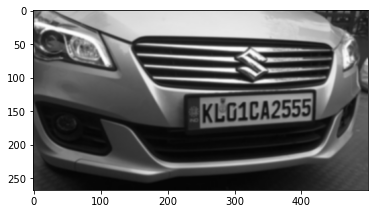

In [17]:
gaussianImg = cv2.GaussianBlur(gsimg, (5, 5), 0)
plt.imshow(cv2.cvtColor(gaussianImg, cv2.COLOR_BGR2RGB))

**Bilateral Filter**


Biilateral Filter of cv2 takes input image, diameter of the pixel neighborhood, sigmaColor, sigmaSpace as parameters. 

Sigmacolor denotes the range of colors that will get mix that means higher the value more distinct colors will start to mix up and sigmaspace denotes the filter sigma in cordinate space.

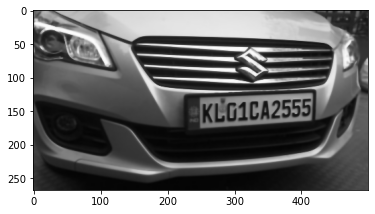

In [25]:
bfilter = cv2.bilateralFilter(gsimg, 5, 75, 75)
plt.imshow(cv2.cvtColor(bfilter, cv2.COLOR_BGR2RGB))

Text(0.5, 1.0, 'Bilateral')

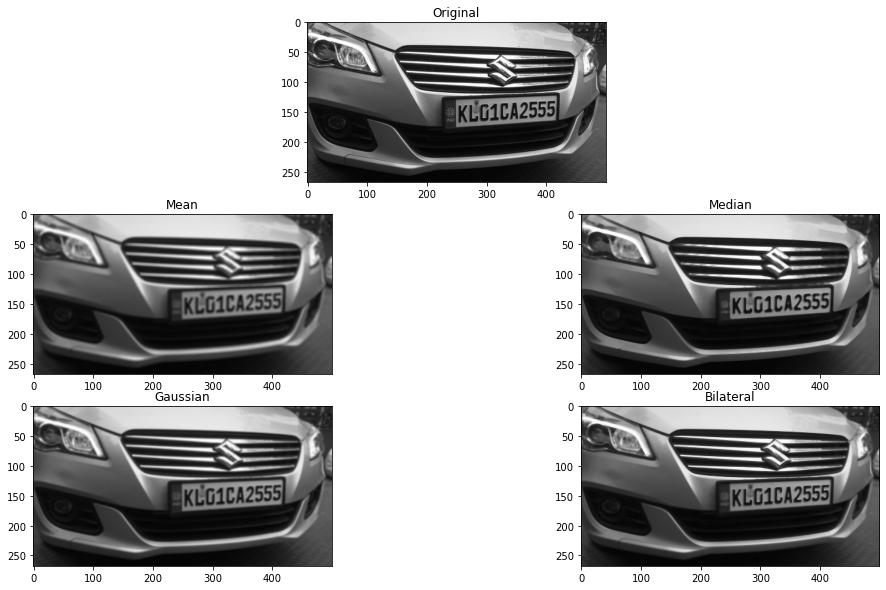

In [26]:
plt.figure(figsize=(18,10))

plt.subplot(311)
plt.imshow(cv2.cvtColor(gsimg, cv2.COLOR_BGR2RGB))
plt.title('Original')

plt.subplot(323)
plt.imshow(cv2.cvtColor(meanImg, cv2.COLOR_BGR2RGB))
plt.title('Mean')

plt.subplot(324)
plt.imshow(cv2.cvtColor(medianImg, cv2.COLOR_BGR2RGB))
plt.title('Median')

plt.subplot(325)
plt.imshow(cv2.cvtColor(gaussianImg, cv2.COLOR_BGR2RGB))
plt.title('Gaussian')

plt.subplot(326)
plt.imshow(cv2.cvtColor(bfilter, cv2.COLOR_BGR2RGB))
plt.title('Bilateral')

As our aim is edge detection and the output of Bilateral filter has the sharpest edges hence we will use the result of bilateral filter for next steps.

# Edge Detection

The commonly used algorithms for edge detection is Sobel algorithm.

Text(0.5, 1.0, 'Sobel y')

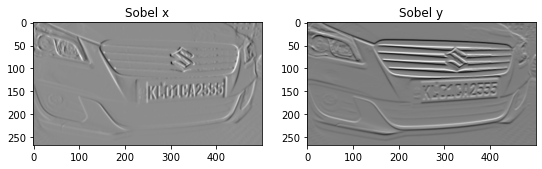

In [35]:
plt.figure(figsize=(9,5))

sobelx = cv2.Sobel(bfilter,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(bfilter,cv2.CV_64F,0,1,ksize=5)

plt.subplot(1,2,1)
plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel x')

plt.subplot(1,2,2)
plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel y')

Another method is Canny algorithm

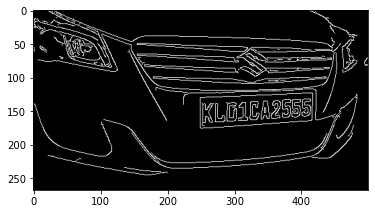

In [3]:
edged = cv2.Canny(bfilter, 30, 200)

plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

The edges are smooth in the output of Sobel algorithm but in case of Canny algorithm, they are more clear. So we will use Canny algorithm in our project.

We got the edges now we have to find the contours. For this we will use ```cv2.findContours(source, contour retrieval mode, contour approximation method)```

Contour retrieval mode tells about how the countours are stored. For example if in a image there is a rectangle and inside it there is a circle, how they will be stored. It can be stored as simple list no connection between the rectangle and circle or as a hierarchy list where the circle is stored under rectangle which tells it is inside the rectangle. Here we are using ```cv2.RETR_TREE``` which stores the countours as a full family hierarchy list.

contour approximation method is about how the contour is represented. A straight line can be represented by all the points on it or by only the 2 end points. By using ```cv2.CHAIN_APPROX_SIMPLE``` we will represent a straight line by 2 points. Here we are looking for rectangle so it will be represented by 4 points.

In [4]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # finds the contours and only consider the corners
contours = imutils.grab_contours(keypoints) # grabs the contours from points
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] # store the sorted top 10 contours by area and remove rest

In [5]:
location = None
for contour in contours: 
    sides = cv2.approxPolyDP(contour, 10, True) # finding the no. of edges of the contours with 10% epsilon i.e 10% of arc length
    if len(sides) == 4:  # rectangle has 4 edges so the largest rectangle in the picture is our plate, running the loop till we find that
        location = sides  # storing the location of largest rectangle and breaking the loop
        break
    
print(location)

[[[417 124]]

 [[249 130]]

 [[249 175]]

 [[415 164]]]


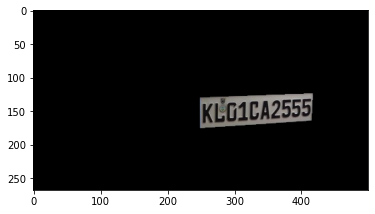

In [6]:
mask = np.zeros(gsimg.shape, np.uint8) # This creates a blank mask of same shape as of the original image
new_image = cv2.drawContours(mask, [location], 0,255, -1) # Drawn our contour out within the image
new_image = cv2.bitwise_and(img, img, mask=mask) # Then we have layed the mask on top of the original image
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

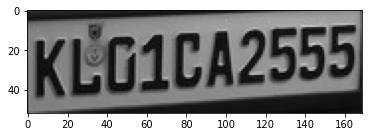

In [7]:
(x, y) = np.where(mask==255) # finding the coordinates of numberplate
(x1, y1) = (np.min(x), np.min(y)) # grab the top left corner
(x2, y2) = (np.max(x), np.max(y)) # grab the bottom right corner
cropped_image = gsimg[x1: x2+1, y1: y2+1] # Crop the image based on the corners
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

# OCR

In [8]:
reader = easyocr.Reader(['en'], gpu = False) # Create the OCR model with english language and running it without gpu
result = reader.readtext(cropped_image) # Identify characters from cropped image

result

Using CPU. Note: This module is much faster with a GPU.


[([[0, 0], [169, 0], [169, 52], [0, 52]], 'KLO1CA2555', 0.523779965784833)]

# Result

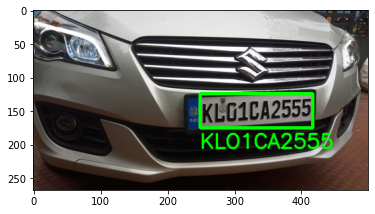

In [9]:
text = result[0][-2] # Grabbed specified text
font = cv2.FONT_HERSHEY_SIMPLEX # Specifid text font 
res = cv2.putText(img, text=text, org=(y1,x2+30), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(sides[0][0]), tuple(sides[2][0]), (0,255,0),3) # This and last line specifies location of text and rectangle on image 
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))